In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from model import wrn_28_2
import torch
from tqdm import tqdm
import torch.nn.functional as F
from ema import EMA,EMADriver, set_ema_model
from train import trainer
from eval import predict, eval
from tqdm import tqdm
from semilearn import get_dataset, get_data_loader, get_net_builder, get_algorithm, get_config, Trainer
# from semilearn.datasets.cv_datasets import get_cifar
from data import get_cifar2
import argparse
from semilearn.core.utils import get_dataset, get_data_loader, get_optimizer, get_cosine_schedule_with_warmup
import matplotlib.pyplot as plt
from flexmatch import FlexMatch2

/opt/conda/envs/usb/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
device = torch.device('cuda:0')

m = wrn_28_2(pretrained=False,pretrained_path=None ,num_classes=10)
_=m.to(device)
ema = wrn_28_2(pretrained=False,pretrained_path=None ,num_classes=10)
ema = set_ema_model(ema, m)
emaA = EMADriver(model=m,ema_model=ema,ema_m=0.999)
# emaA = EMADriver(model=m,ema_model=ema,ema_m=0.999)
emaA.before_run()
NUM_CLASSES=10
args_d = {'dataset': 'cifar10',
         'num_classes': NUM_CLASSES,
         'train_sampler': 'RandomSampler',
         'num_workers': 0,
         'lb_imb_ratio': 1,
         'ulb_imb_ratio':1.0,
          'batch_size': 32,
         'ulb_num_labels': 150,
         'img_size': 32,
         'crop_ratio': 0.875,
         'num_labels': 150,
         'seed': 1,
         'epoch': 3,
         'num_train_iter':150,
         'net': 'wrn_28_8',
         'optim': 'SGD',
         'lr': 0.03,
         'momentum': 0.9,
         'weight_decay': 0.0005,
         'layer_decay': 0.75,
          'num_warmup_iter': 0,
         'algorithm': None,
         'data_dir': './data',
         'uratio': 3,
         'eval_batch_size': 64}

parser = argparse.ArgumentParser(description='Semi-Supervised Learning (USB semilearn package)')
args = parser.parse_args("")
# args
for k in args_d:
        setattr(args, k, args_d[k])
# lb_dset, ulb_dset, eval_dset = get_cifar(args,
#           alg=None, 
#           name='cifar10',
#           num_labels=4000,
#           num_classes=10,
#           data_dir='./data',
#           include_lb_to_ulb=True)
# dataset_dict = get_dataset(args, 
#                            args.algorithm, 
#                            args.dataset, 
#                            args.num_labels, 
#                            args.num_classes, 
#                            data_dir=args.data_dir,
#                           include_lb_to_ulb=False)
dset, eval_dset =  get_cifar2(args, None, 'cifar10', args.num_labels, args.num_classes, data_dir='./data', include_lb_to_ulb=True)

def collate_fn(batch):
    num_labels = 32
    # batch['']
    # print([batch[i]['x_lb'].shape for i in range(min(len(batch),num_labels))])
    idxs_lb= torch.LongTensor([batch[i]['idx_lb'] for i in range(min(len(batch),num_labels))])
    x_lbs= torch.stack([batch[i]['x_lb'] for i in range(min(len(batch),num_labels))])
    y_lbs = torch.LongTensor([batch[i]['y_lb'] for i in range(min(len(batch),num_labels))])
    idxs_ulb= torch.LongTensor([batch[i]['idx_ulb'] for i in range(len(batch))])
    x_ulb_ws= torch.stack([batch[i]['x_ulb_w'] for i in range(len(batch))])
    x_ulb_ss = torch.stack([batch[i]['x_ulb_s'] for i in range(len(batch))])
    # img = torch.Tensor(np.stack([x[0] for x in batch], axis=0))
    # hm = torch.Tensor(np.stack([x[1] for x in batch], axis=0))
    # reg = torch.Tensor(np.stack([x[2] for x in batch], axis=0))
    # wh = torch.Tensor(np.stack([x[3] for x in batch], axis=0))
    # reg_mask = torch.Tensor(np.stack([x[4] for x in batch], axis=0))
    # inds = torch.Tensor(np.stack([x[5] for x in batch], axis=0)).type(torch.int64)
    # in_size = torch.Tensor(np.stack([x[6] for x in batch], axis=0))
    # out_size = torch.Tensor(np.stack([x[7] for x in batch], axis=0))
    # intermediate_size = torch.Tensor(np.stack([x[8] for x in batch], axis=0))
    # scale = torch.Tensor(np.stack([x[9] for x in batch], axis=0))
    # # print(np.vstack([x[10] for x in batch]).shape)
    # boxes_aug = torch.Tensor(np.vstack([x[10] for x in batch]))
    # targets = [x[11] for x in batch]

    return {'idx_lb':idxs_lb,
           'x_lb':x_lbs,
           'y_lb':y_lbs,
           'idx_ulb':idxs_ulb,
           'x_ulb_w':x_ulb_ws,
           'x_ulb_s':x_ulb_ss}

# train_lb_ulb_loader = get_data_loader(args, dset, args.batch_size)
train_lb_ulb_loader = torch.utils.data.DataLoader(dset,
                                        batch_size=32*4,
                                        shuffle=True,
                                        num_workers=0,
                                        pin_memory=True,
                                        collate_fn = collate_fn)
# train_lb_loader = get_data_loader(args, dataset_dict['train_lb'], args.batch_size)
# train_ulb_loader = get_data_loader(args, dataset_dict['train_ulb'], int(args.batch_size * args.uratio))
eval_loader = get_data_loader(args, eval_dset, args.eval_batch_size)

optimizer = get_optimizer(m, args.optim, args.lr, args.momentum, args.weight_decay, args.layer_decay)
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            args.num_train_iter,
                                            num_warmup_steps=args.num_warmup_iter)
loss_ce = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
lb count: [15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
ulb count: [30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
Files already downloaded and verified


In [18]:
for batch in train_lb_ulb_loader:
    print(batch['idx_lb'].shape)
    print(batch['x_lb'].shape)
    print(batch['y_lb'].shape)
    print(batch['idx_ulb'].shape)
    print(batch['x_ulb_w'].shape)
    print(batch['x_ulb_s'].shape)
    break


torch.Size([32])
torch.Size([32, 3, 32, 32])
torch.Size([32])
torch.Size([128])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


In [19]:
dset.ulb_data.shape

(300, 32, 32, 3)

In [20]:
'''
Question, How does training and dataloaders occur when the labeled dataloader finishes, does it loop over and restart
like the moduloud operator N%len(), try that!
'''

'\nQuestion, How does training and dataloaders occur when the labeled dataloader finishes, does it loop over and restart\nlike the moduloud operator N%len(), try that!\n'

In [21]:
# f = FlexMatch(T, 
#              p_cutoff, 
#              ulb_dest_len=len(dataset_dict['train_ulb']),
#              num_classes=10,
#              model=m)

# m = wrn_28_2(pretrained=False,pretrained_path=None ,num_classes=10)
# _=m.to(device)
# ema = wrn_28_2(pretrained=False,pretrained_path=None ,num_classes=10)
# ema = set_ema_model(ema, m)
# emaA = EMADriver(model=m,ema_model=ema,ema_m=0.999)
# emaA = EMADriver(model=m,ema_model=ema,ema_m=0.999)
# emaA.before_run()

f = FlexMatch2(T=1.0, 
             p_cutoff=0.95, 
             ulb_dest_len=len(dset),
             num_classes=NUM_CLASSES,
             model=m,
             ema_model=ema,
             loss_ce=loss_ce,
             scheduler=scheduler,
             optimizer=optimizer,
             device=device,
             train_lb_ulb_loader=train_lb_ulb_loader,
             ulb_loss_ratio=1.0,
             hard_label=True, 
             thresh_warmup=True)

In [26]:
steps, sup_loss,unsup_loss,total_loss, mask_ratio = f.fit(epochs=1000)

100%|██████████| 1000/1000 [18:55<00:00,  1.14s/it]


In [23]:
# mask_ratio

In [24]:
# !nvidia-smi

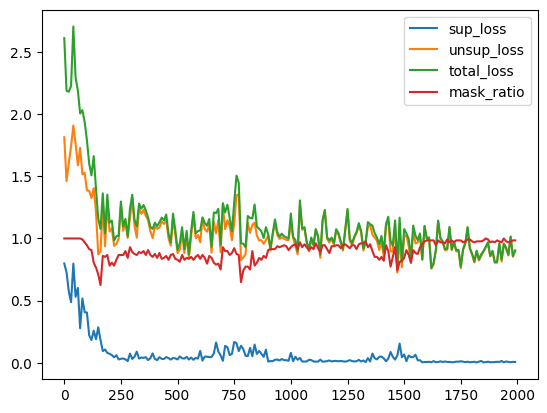

In [27]:
plt.plot(steps,sup_loss)
plt.plot(steps,unsup_loss)
plt.plot(steps,total_loss)
plt.plot(steps,mask_ratio)
#mask_ratio
plt.legend(['sup_loss','unsup_loss','total_loss','mask_ratio'])
plt.show()

In [ ]:
top1,balanced_top1, precision, recall, F1, cf_mat  = eval(m,emaA.ema,eval_loader,device,return_gt=True,use_ema_model=False)
no_ema = {
    'top1':top1,
    'balanced_top1':balanced_top1,
    'precision':precision,
    'recall':recall,
    'F1':F1,
    'cf_mat':cf_mat
}
top1,balanced_top1, precision, recall, F1, cf_mat  = eval(m,emaA.ema,eval_loader,device,return_gt=True,use_ema_model=True)
ema_res = {
    'top1':top1,
    'balanced_top1':balanced_top1,
    'precision':precision,
    'recall':recall,
    'F1':F1,
    'cf_mat':cf_mat
}
for k in ema_res.keys():
    if k!='cf_mat':
        print(k,no_ema[k],ema_res[k])
        plt.bar(['no_ema','ema'],[no_ema[k],ema_res[k]])
        plt.title("{} No EMA vs EMA".format(k))
        plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

self.alg:  None
self.alg: self.alg:  self.alg:  None None
None

self.alg: self.alg: self.alg: self.alg:    None NoneNone
None

self.alg: 
self.alg: self.alg:  self.alg:   NoneNone None

None
self.alg: 
self.alg:  self.alg:  self.alg: None None 
None

Noneself.alg: self.alg: 
 self.alg:  None Noneself.alg: 
None
 
self.alg: Noneself.alg:  self.alg:  
None NoneNone

self.alg: 
self.alg:  self.alg:  self.alg: None None None

None

self.alg: self.alg: self.alg:   self.alg:  NoneNone None

None

self.alg: self.alg: self.alg:   self.alg:  NoneNone None

None

self.alg: self.alg: self.alg:   self.alg:  NoneNoneNone 


Noneself.alg: self.alg: 
self.alg:    self.alg: NoneNoneNone 


Noneself.alg: self.alg: 
self.alg:    Noneself.alg: NoneNone
 

Noneself.alg: self.alg: self.alg: 
   self.alg: NoneNoneNone 


Noneself.alg: self.alg: 
self.alg:    Noneself.alg: NoneNone
 

Noneself.alg: self.alg: 
self.alg:    Noneself.alg: NoneNone
 

Noneself.alg: self.alg: self.alg: 
   Noneself.alg: NoneNone 

  2%|▏         | 1/50 [00:00<00:21,  2.27it/s]


Noneself.alg: 
self.alg: self.alg:    self.alg: NoneNone 
None
None
self.alg: self.alg: 
  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
  Noneself.alg: Noneself.alg: 
 
 Noneself.alg: self.alg: None
  
NoneNoneself.alg: 

self.alg:  self.alg: self.alg: None   
NoneNoneNone

self.alg: 
self.alg:  self.alg: self.alg:  None  None
NoneNone

self.alg: 
self.alg:  self.alg:  self.alg: None None 
NoneNone

self.alg: 
self.alg:  self.alg:  self.alg: None None 
None
None
self.alg: 
self.alg:  self.alg:  self.alg: None None 
None
None
self.alg: 
self.alg:  self.alg:  self.alg: None None 
None
None
self.alg: self.alg: 
 self.alg:  self.alg: None None 
None
None
self.alg: 
self.alg:  self.alg:  self.alg: None None 
None
None
self.alg: 
self.alg:  self.alg:  self.alg: None None 
None
None
self.alg: 
self.alg:  self.alg:  self.alg: None None 
None
None
self.alg: 
self.alg:  self.alg:  self.alg: None None 
NoneNone

self.alg: 
self.alg:  self.alg: self.alg: None   
NoneNoneNone


se

  6%|▌         | 3/50 [00:00<00:07,  6.38it/s]

 None 
self.alg: None self.alg: 

None self.alg: self.alg: 
None  
self.alg: NoneNone 
self.alg: 
None self.alg: 
self.alg: None  
self.alg: NoneNone 
self.alg: 
None self.alg: self.alg: 
None  
Noneself.alg: None

self.alg:  self.alg:  self.alg: None None None

None
self.alg: 
self.alg: self.alg:    self.alg: NoneNoneNone 


Noneself.alg: self.alg: 
self.alg:    self.alg: NoneNoneNone 


Noneself.alg: self.alg: 
self.alg:    self.alg: NoneNoneNone 


Noneself.alg: self.alg: 
self.alg:    NoneNoneself.alg: None

 
Noneself.alg: self.alg: self.alg: 
   Noneself.alg: NoneNone
 

Noneself.alg: self.alg: self.alg: 
   Noneself.alg: NoneNone
 

Noneself.alg: self.alg: self.alg: 
   NoneNoneself.alg: None

 
self.alg: Noneself.alg: self.alg:  
  NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:   
 NoneNoneNone
self.alg: 

 self.alg: self.alg: Noneself.alg

 10%|█         | 5/50 [00:00<00:05,  8.74it/s]

NoneNoneNone
self.alg: 
 
self.alg: self.alg: None self.alg:  
None None
Noneself.alg: 

 self.alg: self.alg: self.alg: None   
NoneNoneNone


self.alg: self.alg: self.alg:   self.alg:  NoneNone None

None
self.alg: 
self.alg: self.alg:    self.alg: NoneNoneNone 


Noneself.alg: self.alg: 
self.alg:   self.alg:  NoneNone None

None
self.alg: self.alg: 
  self.alg: self.alg: NoneNone  

NoneNone
self.alg: self.alg: 
  self.alg: self.alg: NoneNone  

NoneNoneself.alg: 

self.alg:   self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg:  
 self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
  self.alg: self.alg: NoneNone  

NoneNoneself.alg: 

self.alg:   self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: self.alg: 

  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
  self.alg: NoneNoneself.alg:  
 
NoneNoneself.alg: 
self.alg: 
  self.alg: self.alg: NoneNone  

NoneNone
self.alg: self.alg: 
  sel

 14%|█▍        | 7/50 [00:00<00:03, 11.37it/s]

self.alg:  None
 None
Noneself.alg: 
self.alg: 
 self.alg:  Noneself.alg:  None
 None
self.alg: None
self.alg: 
 self.alg:  Noneself.alg:  None
 None
None
self.alg: self.alg: 
  self.alg: self.alg: NoneNone  

NoneNone
self.alg: self.alg: 
  self.alg: self.alg: NoneNone  

NoneNoneself.alg: 
self.alg: 
 self.alg:  Noneself.alg:  None
 None
self.alg: None
 
self.alg: self.alg: None self.alg:  
None None
Noneself.alg: 

self.alg:  self.alg: self.alg:  None  None
NoneNone

self.alg: 
self.alg:  self.alg: self.alg:  None  None
NoneNone

self.alg: 
self.alg:  self.alg: self.alg:  None  None
NoneNone

self.alg: 
self.alg:  self.alg: self.alg:  None  None
None
None
self.alg: 
self.alg: self.alg:  self.alg:   None NoneNone
None

self.alg: 
self.alg:  self.alg: self.alg:  None  None
NoneNone

self.alg: 
self.alg:  self.alg: self.alg:  None  None
NoneNone
self.alg: 

self.alg:   self.alg: self.alg: NoneNone 
 
NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
sel

 18%|█▊        | 9/50 [00:00<00:03, 11.58it/s]

Noneself.alg: 
 
 Noneself.alg: self.alg: None
 
 Noneself.alg: Noneself.alg: 
 
 Noneself.alg: None
 self.alg: 
None self.alg: self.alg: 
None  
Noneself.alg: None
self.alg:  
 self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
  Noneself.alg: Noneself.alg: 
 
 Noneself.alg: Noneself.alg: 
 
 Noneself.alg: Noneself.alg: 
 
 Noneself.alg: Noneself.alg: 
 
 Noneself.alg: Noneself.alg: 
 
 self.alg: NoneNoneself.alg:  

 Noneself.alg: Noneself.alg: 
 
 self.alg: Noneself.alg: None
  
Noneself.alg: Noneself.alg: 
 
 Noneself.alg: Noneself.alg: 
 
 Noneself.alg: Noneself.alg: 
 
 self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
 self.alg:  None self.alg: None
None 

self.alg: Noneself.alg:  
self.alg:  None self.alg: None
None 

Noneself.alg: self.alg: self.alg: 
   Noneself.alg: NoneNone
 

self.alg: Noneself.alg: self.alg:  
  NoneNoneself.alg: None

 
self.alg: Noneself.alg: self.alg:  
  NoneNoneself.alg: None


 self.alg: Noneself.alg: self.alg:  
  NoneNoneNon

 24%|██▍       | 12/50 [00:01<00:02, 14.82it/s]

 
Noneself.alg: Noneself.alg: 
 
 Noneself.alg: Noneself.alg: 
 
 Noneself.alg: Noneself.alg: 
 
 Noneself.alg: Noneself.alg: 
  
Noneself.alg: Noneself.alg: 
 
 Noneself.alg: Noneself.alg: 
 
 Noneself.alg: Noneself.alg: 

  NoneNoneself.alg: self.alg: 

  self.alg: self.alg: NoneNone  

NoneNone

self.alg: self.alg: self.alg:  self.alg:   NoneNone NoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg:  self.alg:   None NoneNone
Non

 28%|██▊       | 14/50 [00:01<00:02, 13.02it/s]


 None Noneself.alg: 
None 

self.alg: Noneself.alg:  self.alg: 
 None Noneself.alg: 
None 

self.alg: Noneself.alg:  
self.alg:  None self.alg: None
None
 
self.alg: Noneself.alg:  
self.alg:  None Noneself.alg: 
None
 self.alg: 
Noneself.alg:  
self.alg:  None self.alg: None
None 
self.alg: 
Noneself.alg:  
self.alg:  Noneself.alg: None 
 
NoneNoneself.alg: self.alg: 

  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: self.alg: 

  self.alg: self.alg: NoneNone  

NoneNoneself.alg: 
self.alg: 
  self.alg: self.alg: None None 
None
None
self.alg: 
self.alg:  self.alg:  self.alg: None None
 None
Noneself.alg: 

self.alg:  self.alg:  None self.alg: None
None 

self.alg: None self.alg: self.alg: 
None  self.alg: 
NoneNone 

self.alg: None self.alg: self.alg: 
None  self.alg: 
NoneNone 
self.alg: 
None 
self.alg: self.alg: None self.alg: 
 None Noneself.alg: 
None
 
self.alg: Noneself.alg:  
self.alg:  NoneNone self.alg: 
None
 
self.alg: Noneself.alg:  
 self.alg: None Noneself.alg: 
No

 34%|███▍      | 17/50 [00:01<00:02, 13.31it/s]


self.alg:  self.alg: self.alg:  None  None
NoneNone

self.alg: 
self.alg:  self.alg: self.alg:  None  None
NoneNone

self.alg: 
self.alg:  self.alg: self.alg:  None None 
NoneNone

self.alg: 
self.alg:  self.alg: self.alg:  None  None
NoneNone

self.alg: 
self.alg:  self.alg:  self.alg: None None 
None
None
self.alg: 
self.alg: self.alg:   self.alg:  NoneNone None

None
self.alg: 
self.alg: self.alg:  self.alg:   NoneNone None

None
self.alg: 
self.alg: self.alg:    Noneself.alg: NoneNone
 

self.alg: Noneself.alg: self.alg:  
  NoneNoneself.alg: None


 self.alg: self.alg: self.alg: None   
NoneNoneNone

self.alg: 
 self.alg: self.alg: self.alg: None   
NoneNoneNoneself.alg: 


 self.alg: Noneself.alg: self.alg:  
  NoneNoneself.alg: None

 
self.alg: Noneself.alg: self.alg:  
  NoneNoneself.alg: None

 
self.alg: Noneself.alg: self.alg:   
NoneNoneNoneself.alg: 
 

 self.alg: None
  None None


 Noneself.alg:  
 self.alg: NoneNone self.alg: self.alg: self.alg: Noneself.alg: self.alg

 40%|████      | 20/50 [00:01<00:01, 15.71it/s]


 None Noneself.alg: 
None
 
self.alg: Noneself.alg:  self.alg: 
 None None
self.alg: None
 
self.alg: Noneself.alg:  self.alg:  
None Noneself.alg: 
None
 
self.alg: Noneself.alg:  self.alg: 
 NoneNone self.alg: 
None
 
self.alg: self.alg: None self.alg: 
 NoneNone self.alg: 
None
 
self.alg: Noneself.alg:  self.alg: 
  NoneNoneself.alg: None

 
self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:   
 NoneNoneself.alg: 
None

 self.alg: Noneself.alg: self.alg:  
  NoneNoneself.alg: 

None self.alg: 
self.alg: None  
self.alg: NoneNone self.alg: 

None self.alg: self.alg: 
None  
self.alg: NoneNone self.alg: 

None self.alg: self.alg: 
None  
self.alg: NoneNone self.alg: 

None self.alg: self.alg: 
None  
self.alg: NoneNone 
self.alg: 
None self.alg: self.alg: 
None  
self.alg: NoneNone self.alg: 

None self.alg: self.alg: 
None  
self.alg: NoneNoneself.alg: 
 
 Noneself.alg: self.alg: None
  
Noneself.alg: Noneself.alg: 
 
 Noneself.alg: No

 44%|████▍     | 22/50 [00:01<00:02, 13.43it/s]


self.alg: 
self.alg:  self.alg:  self.alg: None None 
None
None
self.alg: 
self.alg:  self.alg:  self.alg:  NoneNone None

None
self.alg: self.alg: 
self.alg:   self.alg:  NoneNoneNone 


Noneself.alg: self.alg: 
self.alg:   self.alg:  NoneNone None

None
self.alg: 
self.alg: self.alg:    self.alg: NoneNone None


Noneself.alg: 
self.alg: self.alg:   self.alg:  NoneNone None

None
self.alg: 
self.alg: self.alg:   self.alg:  NoneNone None

None

self.alg: self.alg: self.alg:   self.alg:  NoneNone None

None

self.alg: self.alg: self.alg:    self.alg: NoneNone None

None
self.alg: 
self.alg: self.alg:  self.alg:   None NoneNone
None
self.alg: 
self.alg: 
 self.alg:  None None 
None
self.alg: 

self.alg: None self.alg: self.alg: self.alg:  None  None
NoneNone

self.alg: 
self.alg: self.alg:   self.alg:  NoneNone None

None
self.alg: 
self.alg: self.alg:   self.alg:  NoneNone None

None

self.alg: self.alg: self.alg:   self.alg:  None NoneNone

None
self.alg: 
self.alg: self.alg:    self.

 50%|█████     | 25/50 [00:02<00:01, 13.46it/s]

NoneNoneself.alg: 

 
self.alg: Noneself.alg:  self.alg: 
 None None
self.alg: None
self.alg:  
self.alg:  Noneself.alg:  None
 
Noneself.alg: None
self.alg: 
  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
  self.alg: NoneNoneself.alg:  

None self.alg: 
None self.alg: 
self.alg: None  self.alg: 
NoneNone 
self.alg: 
None self.alg: 
self.alg: None  self.alg: 
NoneNone 
self.alg: 
None self.alg: 
self.alg: None  self.alg: 
NoneNone 
self.alg: None
 
self.alg: self.alg: None  
self.alg: NoneNone self.alg: 

None 
self.alg: self.alg: None self.alg:  
None None
self.alg: 
None self.alg: 
self.alg: None  
self.alg: NoneNone
 
self.alg: Noneself.alg:  self.alg: 
  NoneNoneNoneself.alg: 


 self.alg: self.alg: self.alg: None   
NoneNoneNone

self.alg: 
self.alg:  self.alg: self.alg:  None  None
NoneNone

self.alg: 
self.alg:  self.alg: self.alg:  None  None
NoneNone


self.alg: self.alg: self.alg:  self.alg:   None NoneNone
None

self.alg: 
self.alg: self.alg:    self.alg: No

 56%|█████▌    | 28/50 [00:02<00:01, 15.78it/s]

self.alg: None
None 

self.alg: Noneself.alg: 
self.alg:   None self.alg: None
None
 
self.alg: Noneself.alg:  self.alg: 
 None Noneself.alg: 
None
 
self.alg: Noneself.alg:  self.alg: 
 None self.alg: None
None
 
self.alg: Noneself.alg:  self.alg: 
 None Noneself.alg: 
None
 self.alg: 
Noneself.alg:  self.alg: 
 None None
self.alg: None
 
self.alg: Noneself.alg:  self.alg: 
 None Noneself.alg: 
None
 
self.alg: Noneself.alg:  self.alg: 
 None Noneself.alg: 
None
 
self.alg: Noneself.alg:  self.alg: 
 None Noneself.alg: 
None
 
self.alg: Noneself.alg:  self.alg:  
None Noneself.alg: 
None
 
self.alg: self.alg: Noneself.alg:   
 NoneNoneself.alg: None

 
self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 


 self.alg: Noneself.alg: self.alg:  
  NoneNoneNoneself.alg: 

 
self.alg: Noneself.alg: self.alg:   
 NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 


 self.alg: self.alg: self.alg: None   
NoneNoneNone
self.alg: 

 self.alg: self.alg

 60%|██████    | 30/50 [00:02<00:01, 13.92it/s]


self.alg: 
Noneself.alg:  
self.alg: None  self.alg: None
None 

self.alg: Noneself.alg:  self.alg: 
 None None
Noneself.alg: 

self.alg:  self.alg:  self.alg: None  None
None
None

self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNone
None


self.alg: self.alg: self.alg:  self.alg:   None NoneNone
None


self.alg: self.alg: self.alg:  self.alg:   NoneNone None

None
self.alg: 
self.alg: self.alg:    self.alg: NoneNone None

None
self.alg: 
self.alg: self.alg:    self.alg: NoneNone None

None
self.alg: 
self.alg: self.alg:   self.alg:  NoneNoneNone 


Noneself.alg: self.alg: 
self.alg:    self.alg: NoneNoneNone 

None
self.alg: 
self.alg: self.alg:   self.alg:  NoneNone None

None
self.alg: 
self.alg: self.alg:   self.alg:  NoneNone None

None
self.alg: 
self.alg: self.alg:    self.alg: NoneNoneNone 

None
self.alg: self.alg: 
self.alg:    self.alg: NoneNo

 66%|██████▌   | 33/50 [00:02<00:01, 13.27it/s]

NoneNoneself.alg: None

 
self.alg: self.alg: None self.alg:  
 NoneNoneself.alg: 
None
 
self.alg: self.alg: None self.alg:  
None None
self.alg: None
 
self.alg: self.alg: None self.alg:  
None Noneself.alg: 
None
 
self.alg: self.alg: None self.alg:  
None Noneself.alg: 
None
 self.alg: 
self.alg: None self.alg:  
None Noneself.alg: 
None
 self.alg: 
self.alg: None self.alg:  
None None
self.alg: None
 self.alg: 
Noneself.alg:  
self.alg:  None self.alg: None
None 
self.alg: 
Noneself.alg:  
self.alg:  None self.alg: None
None 
self.alg: 
Noneself.alg:  
self.alg:  None self.alg: None
None 

self.alg: Noneself.alg:  self.alg: 
 None self.alg: None
None 

self.alg: Noneself.alg:  self.alg: 
 None Noneself.alg: 
None
 
self.alg: Noneself.alg:  self.alg: 
 None Noneself.alg: 
None
 self.alg: 
Noneself.alg:  self.alg: 
 None Noneself.alg: 
None
 
self.alg: Noneself.alg:  self.alg: 
 None Noneself.alg: 
None
 
self.alg: self.alg: None self.alg:  
None Noneself.alg: 
None
 self.alg: 
None

 72%|███████▏  | 36/50 [00:02<00:00, 15.52it/s]

None  self.alg: 
NoneNone 
self.alg: 
None self.alg: 
self.alg: None  self.alg: 
NoneNone 
self.alg: 
None self.alg: 
self.alg: None  self.alg: 
NoneNone 
self.alg: 
None self.alg: 
self.alg: None  self.alg: 
NoneNone 
self.alg: 
None self.alg: 
self.alg: None  self.alg: None
None 

self.alg: Noneself.alg:  
self.alg:  None self.alg: None
None 

self.alg: Noneself.alg: self.alg:  
  NoneNoneself.alg: None

 
self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:   
 NoneNoneNone
self.alg: 

 self.alg: self.alg: Noneself.alg:   
 NoneNoneNone
self.alg: 

 self.alg: self.alg: Noneself.alg:   
 NoneNoneNone
self.alg: 

 self.alg: self.alg: self.alg: None   
NoneNoneNone
self.alg: 

 self.alg: self.alg: self.alg: None   None
NoneNone

self.alg: 
self.alg: self.alg:   self.alg:  NoneNone None

None
self.alg: self.alg: 
self.alg:    self.alg: NoneNoneNone 


Noneself.alg: 
self.alg: sel

 76%|███████▌  | 38/50 [00:02<00:00, 13.62it/s]

None 
self.alg: 
Noneself.alg:  
self.alg:  NoneNone 
self.alg: 
None self.alg: 
self.alg: None self.alg:  
None Noneself.alg: 
None
 
self.alg: Noneself.alg:  self.alg: 
 None Noneself.alg: 
None
 
self.alg: Noneself.alg:  self.alg: 
 None Noneself.alg: 
None
 
self.alg: Noneself.alg: self.alg:  
  NoneNoneNoneself.alg: 


 self.alg: self.alg: self.alg: None  
 NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:   
 NoneNoneNone
self.alg: 

 self.alg: self.alg: Noneself.alg:   
 NoneNoneNone

self.alg: 
self.alg:  self.alg: self.alg:  None  None
NoneNone

self.alg: 
self.alg: self.alg:    self.alg: NoneNoneNone 


Noneself.alg: self.alg: self.alg: 
   Noneself.alg: NoneNone
 

Noneself.alg: self.alg: self.alg: 
   Noneself.alg: NoneNone
 

self.alg: Noneself.alg: self.alg:  
  NoneNoneself.alg: None

 
Noneself.alg: self.alg: self.alg: 
   NoneNoneself.alg: None

 
self.alg: Noneself.alg: self.alg:  
  NoneNoneself.alg: None


 self.alg: self.alg: Noneself.alg:   
 NoneNoneNon

 82%|████████▏ | 41/50 [00:03<00:00, 13.16it/s]


self.alg: None self.alg: 
self.alg: None  None
self.alg: None
 self.alg: 
self.alg:  Noneself.alg:  None
 None
Noneself.alg: 

 self.alg: self.alg: None self.alg:  
None Noneself.alg: 
None
 
self.alg: self.alg: None self.alg:  
None None
self.alg: None
 self.alg: 
self.alg: None  self.alg: 
NoneNone 
self.alg: 
None self.alg: 
self.alg: None  self.alg: 
NoneNone self.alg: 

None 
self.alg: self.alg: None  self.alg: 
NoneNone 
self.alg: 
None self.alg: 
self.alg: None  self.alg: 
NoneNone 
self.alg: 
None self.alg: 
self.alg: None  self.alg: 
NoneNone 

Noneself.alg: 
self.alg:  self.alg:  self.alg: None None 
None
None
self.alg: 
self.alg:  self.alg:  self.alg: None None 
None
None
self.alg: 
self.alg:  self.alg:  self.alg:  NoneNone None

None

self.alg: self.alg: self.alg:   self.alg:  NoneNone None

None
self.alg: 
self.alg: self.alg:   self.alg:  NoneNone None

None
self.alg: self.alg: 
self.alg:    Noneself.alg: NoneNone
 

Noneself.alg: self.alg: 
self.alg:    Noneself.alg: Non

 88%|████████▊ | 44/50 [00:03<00:00, 15.72it/s]


  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg: None
  
NoneNoneself.alg: self.alg: 

  Noneself.alg: self.alg: None
 
 Noneself.alg: Noneself.alg: 
 
 Noneself.alg: Noneself.alg: 
 
 Noneself.alg: Noneself.alg: 
 
 Noneself.alg: self.alg: None
 
 Noneself.alg: Noneself.alg: 
 
 self.alg: NoneNoneself.alg:  
 
Noneself.alg: None
self.alg:  
 self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg: None 

 NoneNoneself.alg: self.alg: 

  self.alg: NoneNoneself.alg:  
 
NoneN

 92%|█████████▏| 46/50 [00:03<00:00, 14.15it/s]


self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.alg: self.alg:   NoneNone

self.al

  0%|          | 0/50 [00:00<?, ?it/s]

self.alg: self.alg: self.alg:   NoneNone
 
Noneself.alg: 
self.alg:   self.alg: NoneNone self.alg: 

None self.alg: self.alg: 
None  self.alg: 
NoneNone 

self.alg: Noneself.alg:  self.alg: 
 None self.alg: None
None 

self.alg: Noneself.alg:  self.alg: 
 None Noneself.alg: 
None
 
self.alg: Noneself.alg:  self.alg: 
 None Noneself.alg: 
None
 
self.alg: Noneself.alg: self.alg:   
 NoneNoneself.alg: None

 
self.alg: Noneself.alg: self.alg:  
  NoneNoneself.alg: None

 
self.alg: self.alg: self.alg: None  
 NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:    
NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:   
 NoneNoneself.alg: None

 
self.alg: self.alg: Noneself.alg:   
 NoneNoneself.alg: None

 
self.alg: sel

  2%|▏         | 1/50 [00:00<00:21,  2.27it/s]

Noneself.alg: Noneself.alg: 
 
 Noneself.alg: Noneself.alg: 
 
 Noneself.alg: self.alg: None
  
self.alg: NoneNoneself.alg:  

 NoneNoneself.alg: self.alg: 

  self.alg: NoneNoneself.alg:  
 
NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 

 self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:   
 NoneNoneself.alg: None


 self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 

 
self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:    
NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:  
  NoneNoneself.alg: None

 
self.alg: Noneself.alg: self.alg:   
 NoneNoneNoneself.alg: 


 self.alg: self.alg:

  8%|▊         | 4/50 [00:00<00:05,  8.54it/s]

  
NoneNoneNoneself.alg: 


 self.alg: self.alg: self.alg: None   
NoneNoneNoneself.alg: 


 Noneself.alg: self.alg: self.alg: 
   Noneself.alg: NoneNone
 

Noneself.alg: self.alg: self.alg: 
   Noneself.alg: NoneNone
 

Noneself.alg: self.alg: 
self.alg:    Noneself.alg: NoneNone
 

Noneself.alg: self.alg: 
self.alg:    Noneself.alg: NoneNone
 

Noneself.alg: self.alg: 
self.alg:    Noneself.alg: NoneNone

 
Noneself.alg: self.alg: self.alg: 
   Noneself.alg: NoneNone
 

Noneself.alg: 
self.alg:  self.alg: None self.alg:  
None NoneNone
self.alg: 

 self.alg: self.alg: self.alg: None  
 NoneNoneNone
self.alg: self.alg: 
 
 Noneself.alg: self.alg: None
  
Noneself.alg: Noneself.alg: 
 
 Noneself.alg: Noneself.alg: 
  
NoneNoneself.alg: self.alg: 

  self.alg: NoneNoneself.alg:  

 NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg: None 
 
NoneNone
self.alg: self.alg: 
  self.alg: self.alg: NoneNone  

NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg:  None
 None
self.alg: No

 12%|█▏        | 6/50 [00:00<00:04,  9.15it/s]


Noneself.alg: self.alg: self.alg: 
   NoneNoneself.alg: None

 
Noneself.alg: self.alg: self.alg: 
   NoneNoneself.alg: None

 
self.alg: Noneself.alg: self.alg:  
  NoneNoneself.alg: None

 
self.alg: Noneself.alg: self.alg:  
  NoneNoneself.alg: None

 
self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 


 self.alg: Noneself.alg: self.alg:  
  NoneNoneself.alg: None

 
self.alg: Noneself.alg: self.alg:   
 NoneNoneNone
self.alg: 

self.alg:  self.alg:  self.alg: None None 
None
Noneself.alg: 

 self.alg: self.alg: self.alg: None   
NoneNoneNone
self.alg: 

 self.alg: self.alg: self.alg: None   
NoneNoneNone

self.alg: 
self.alg:  self.alg: self.alg:  None  None
NoneNone

self.alg: 
self.alg:  self.alg: self.alg:  None  None
NoneNone

self.alg: 
self.alg:  self.alg: self.alg:  None  None
NoneNone


self.alg: self.alg:  self.alg: self.alg:  None  None
NoneNone

self.alg: 
self.alg:  self.alg: self.alg:  None  None
NoneNone

self.alg: 
self.alg:  self.alg: self.alg:  None  No

 18%|█▊        | 9/50 [00:00<00:03, 11.11it/s]

self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 

self.alg:   self.alg: self.alg: NoneNone  

NoneNone
self.alg: self.alg: 
  self.alg: self.alg: NoneNone  

NoneNoneself.alg: 

self.alg:   self.alg: self.alg: NoneNone 
 
NoneNoneself.alg: 
self.alg: 
  self.alg: NoneNoneself.alg:  

 Noneself.alg: Noneself.alg: 
 
 Noneself.alg: Noneself.alg: 
 
 Noneself.alg: Noneself.alg: 
  
Noneself.alg: None
 
self.alg: Noneself.alg:  self.alg: 
 None Noneself.alg: None

 
Noneself.alg: self.alg: self.alg: 
   Noneself.alg: NoneNone
 

Noneself.alg: self.alg: 
 self.alg:  Noneself.alg:  None
 
NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
  self.alg: NoneNoneself.alg:   

NoneNoneself.alg: self.alg: 

  self.alg: NoneNoneself.alg:  

 NoneNoneself.alg: self.alg: 
  
self.alg: NoneNone 
self.alg: None
 self.alg: 
 self.alg

 24%|██▍       | 12/50 [00:01<00:02, 14.13it/s]

self.alg: NoneNoneNone 


Noneself.alg: self.alg: 
self.alg:    self.alg: NoneNoneNone 


Noneself.alg: self.alg: 
self.alg:    Noneself.alg: NoneNone
 

Noneself.alg: 
self.alg: self.alg:    self.alg: NoneNoneNone 


Noneself.alg: 
self.alg: self.alg:    Noneself.alg: None
None 

Noneself.alg: self.alg: 
self.alg:    Noneself.alg: NoneNone
 

Noneself.alg: self.alg: 
self.alg:    Noneself.alg: NoneNone
 

Noneself.alg: self.alg: 
self.alg:    Noneself.alg: NoneNone
 

Noneself.alg: self.alg: self.alg: 
   Noneself.alg: NoneNone
 

Noneself.alg: self.alg: self.alg: 
   Noneself.alg: NoneNone
 

Noneself.alg: self.alg: 
 self.alg:   Noneself.alg: NoneNone
 

Noneself.alg: self.alg: 
self.alg:    Noneself.alg: NoneNone
 

Noneself.alg: self.alg: self.alg:  
  Noneself.alg: NoneNone
 

self.alg: Noneself.alg: self.alg:  
  NoneNoneself.alg: 
None
 
self.alg: Noneself.alg: self.alg:  
  NoneNoneself.alg: None

 
Noneself.alg: self.alg: self.alg: 
   Noneself.alg: NoneNone
 

Noneself.alg: 

 28%|██▊       | 14/50 [00:01<00:02, 12.76it/s]

self.alg:  self.alg:   None NoneNone
None


self.alg: self.alg: self.alg:  self.alg:   None NoneNone
None


self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg:  self.alg:  NoneNone  

NoneNo

 34%|███▍      | 17/50 [00:01<00:02, 13.25it/s]



 
self.alg: Noneself.alg:  self.alg: 
  NoneNoneself.alg: 
None
 
self.alg: Noneself.alg:  self.alg: 
 None Noneself.alg: 
None
 
self.alg: Noneself.alg: self.alg:  
  NoneNoneself.alg: None

 
self.alg: Noneself.alg: self.alg:  
  NoneNoneNoneself.alg: 


 self.alg: Noneself.alg: self.alg:   
 NoneNoneself.alg: None

 
Noneself.alg: self.alg: self.alg: 
   NoneNoneself.alg: None

 
Noneself.alg: self.alg: self.alg: 
   NoneNoneself.alg: None

 
self.alg: Noneself.alg: self.alg:  
  NoneNoneNoneself.alg: 


 self.alg: Noneself.alg: self.alg:  
  Noneself.alg: NoneNone
 

self.alg: Noneself.alg: self.alg:  
  NoneNone
Noneself.alg: 
self.alg: 
 self.alg:  self.alg: None None None

None

self.alg: self.alg: self.alg:   self.alg:  NoneNone None

None
self.alg: 
self.alg: self.alg:   self.alg:  NoneNone None

None
self.alg: 
self.alg: self.alg:    self.alg: NoneNone None

None
self.alg: 
self.alg: self.alg:   self.alg:  NoneNone None

None
self.alg: self.alg: 
self.alg:   self.alg:  None

 40%|████      | 20/50 [00:01<00:01, 15.62it/s]

None
self.alg: None
 
self.alg: self.alg: None self.alg:  
NoneNone self.alg: 

None self.alg: 
self.alg: None  
self.alg: NoneNone 
self.alg: 
None self.alg: 
self.alg: None  
self.alg: NoneNone 
self.alg: 
None self.alg: 
self.alg: None  
self.alg: NoneNone 
self.alg: 
None self.alg: self.alg: 
None  
self.alg: NoneNone self.alg: 

None self.alg: self.alg: 
None  
self.alg: NoneNone 
self.alg: 
None self.alg: 
self.alg: None  
self.alg: NoneNone 
self.alg: 
None self.alg: 
self.alg: None  
self.alg: NoneNone 
self.alg: 
None self.alg: 
self.alg: None  
self.alg: NoneNone 
self.alg: 
None 
self.alg: Noneself.alg:  
self.alg:  None Noneself.alg: 
None
 
self.alg: self.alg: Noneself.alg:   
 NoneNoneself.alg: None

 
self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:   
 NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:   
 NoneNoneself.alg: None

 
self.alg: self.alg

 44%|████▍     | 22/50 [00:01<00:02, 13.55it/s]

NoneNone
 

Noneself.alg: self.alg: self.alg: 
   Noneself.alg: NoneNone
 

Noneself.alg: self.alg: self.alg: 
   Noneself.alg: NoneNone
 

Noneself.alg: self.alg: self.alg: 
   NoneNoneself.alg: None

 
self.alg: Noneself.alg: self.alg:  
  NoneNoneNone
self.alg: 

 self.alg: self.alg: Noneself.alg:  
  NoneNoneNoneself.alg: 


 self.alg: self.alg: Noneself.alg:  
  NoneNoneself.alg: None


 self.alg: Noneself.alg: self.alg:  
  NoneNoneNoneself.alg: 


 self.alg: Noneself.alg: self.alg:  
  NoneNoneself.alg: None

 
self.alg: self.alg: Noneself.alg:  
  NoneNoneself.alg: None

 
self.alg: Noneself.alg:  self.alg: 
 None Noneself.alg: 
None
 
self.alg: Noneself.alg:  self.alg: 
 None Noneself.alg: 
None
 
self.alg: Noneself.alg: self.alg:  
 None Noneself.alg: 
None
 
self.alg: Noneself.alg:  self.alg: 
 None Noneself.alg: 
None
 
self.alg: Noneself.alg:  self.alg: 
 None Noneself.alg: 
None
 
self.alg: Noneself.alg: self.alg:  
  NoneNoneNoneself.alg: 

 
self.alg: Noneself.alg: self

 50%|█████     | 25/50 [00:02<00:01, 13.77it/s]

None self.alg: 
self.alg:   self.alg: NoneNoneNone 


Noneself.alg: 
self.alg: self.alg:    self.alg: NoneNoneNone 


None
self.alg: self.alg: self.alg:    self.alg: NoneNoneNone 


Noneself.alg: self.alg: 
self.alg:    self.alg: NoneNoneNone 


Noneself.alg: 
self.alg: self.alg:    Noneself.alg: NoneNone
 

Noneself.alg: self.alg: 
self.alg:    Noneself.alg: NoneNone
 

Noneself.alg: self.alg: 
self.alg:    self.alg: NoneNoneNone 


Noneself.alg: self.alg: 
self.alg:    Noneself.alg: NoneNone
 

Noneself.alg: self.alg: 
self.alg:    self.alg: NoneNoneNone 


Noneself.alg: self.alg: 
self.alg:    self.alg: NoneNoneNone 


Noneself.alg: self.alg: self.alg: 
   Noneself.alg: NoneNone
 

Noneself.alg: self.alg: self.alg: 
   self.alg: NoneNoneNone
 

Noneself.alg: self.alg: self.alg: 
   Noneself.alg: NoneNone
 

Noneself.alg: self.alg: self.alg: 
   Noneself.alg: NoneNone
 

Noneself.alg: self.alg: self.alg: 
   Noneself.alg: NoneNone
 

Noneself.alg: self.alg: 
self.alg:    self.alg: No

 56%|█████▌    | 28/50 [00:02<00:01, 15.78it/s]


self.alg:  self.alg:  self.alg: None None 
None
None

self.alg: self.alg:   self.alg: self.alg: NoneNone  

NoneNoneself.alg: self.alg: 

  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg: None 
 
NoneNoneself.alg: 
self.alg: 
 self.alg:  self.alg: NoneNone  

NoneNoneself.alg: 
self.alg: 
 self.alg:  Noneself.alg:  None
 None
Noneself.alg: 

self.alg:  self.alg:  Noneself.alg:  None 
None
Noneself.alg: 

self.alg:  self.alg:  self.alg: None None 
None
None
self.alg: 
self.alg:  self.alg:  self.alg: None None None
None


self.alg: self.alg: self.alg: self.alg:    None NoneNone
None

self.alg: 
self.alg: self.alg:  self.alg:   None NoneNone

None
self.alg: 
self.alg: self.alg:  self.alg:   None None
None
None
self.alg: 
self.alg: self.alg:   self.alg:  NoneNone None

None
self.alg: 
self.alg: self.alg:   self.alg: NoneNone  NoneNone


self.alg: 
self.alg: self.alg:   self.alg:  NoneNone None
None

self.alg: 
self.alg: self.alg:   self.alg:  NoneNo

 60%|██████    | 30/50 [00:02<00:01, 13.48it/s]

self.alg: NoneNone 


Noneself.alg: 
self.alg:  self.alg:  Noneself.alg:  None
None 

Noneself.alg: self.alg: 
 self.alg:  None self.alg: None
None 

Noneself.alg: self.alg: 
 self.alg:  None self.alg: None
None 

Noneself.alg: self.alg: 
 self.alg:  self.alg: None None None

None
self.alg: 
self.alg: self.alg:   self.alg:  NoneNoneNone 


Noneself.alg: 
self.alg: self.alg:   self.alg:  NoneNoneNone 


Noneself.alg: self.alg: 
self.alg:    self.alg: NoneNoneNone 


Noneself.alg: self.alg: 
self.alg:    self.alg: NoneNone 
None
None
self.alg: 
self.alg:  self.alg: self.alg:  None  
NoneNoneNone


self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg: self.alg: self.alg:     NoneNoneNoneNone



self.alg: self.alg:  self.alg: self.alg:  None  None
None
None
self.alg: 
self.alg:  self.alg:  Noneself.alg:  None 
None
None
self.alg: 
self.alg:  self.alg:  self.alg: None None 
None
None
self.alg: 
sel

 66%|██████▌   | 33/50 [00:02<00:01, 13.80it/s]

self.alg:  None NoneNone
None


self.alg: self.alg: self.alg:  self.alg:   None NoneNone
None

self.alg: 
self.alg:  self.alg: self.alg:  None  None
NoneNone

self.alg: 
self.alg: self.alg:   self.alg:  NoneNone 
None
None
self.alg: self.alg:  self.alg: self.alg:  
None None 
NoneNone

self.alg: 
self.alg: self.alg:   self.alg:  NoneNone None

None
self.alg: 
self.alg: self.alg:   self.alg:  NoneNone None

None
self.alg: self.alg: 
self.alg:    self.alg: NoneNoneNone 


Noneself.alg: self.alg: 
self.alg:    self.alg: NoneNoneNone 

None
self.alg: self.alg: 
self.alg:   self.alg:  NoneNone None

None
self.alg: self.alg: 
self.alg:    self.alg: NoneNone 
None

Noneself.alg: self.alg:  
self.alg:  NoneNone self.alg: 

None self.alg: self.alg: 
None  None
self.alg: None
 self.alg: 
Noneself.alg:  self.alg: 
 NoneNone self.alg: 

None self.alg: None
self.alg:  
 self.alg: NoneNoneself.alg:  

 Noneself.alg: Noneself.alg: 
 
 Noneself.alg: Noneself.alg: 
 
 Noneself.alg: Noneself.alg: 
 
 No

 72%|███████▏  | 36/50 [00:02<00:00, 15.93it/s]


 
NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg: None 
 
NoneNone
self.alg: self.alg: 
  self.alg: Noneself.alg:  None
 
NoneNoneself.alg: 
self.alg: 
  self.alg: Noneself.alg: None 
 
Noneself.alg: None
self.alg:  
self.alg:  Noneself.alg: None 
 
NoneNoneself.alg: self.alg: 

  self.alg: self.alg: NoneNone  

NoneNone
self.alg: self.alg: 
  self.alg: self.alg: NoneNone  

NoneNoneself.alg: 

self.alg:  self.alg:  self.alg: None None 
None
Noneself.alg: 

self.alg:  self.alg:  self.alg: None None 
None
None
self.alg: 
self.alg:  self.alg:  self.alg: None None 
None
None
self.alg: 
self.alg:  self.alg:  self.alg: None None 
None
None
self.alg: 
self.alg:  self.alg:  self.alg: None None 
None
None
self.alg: 
self.alg:  self.alg:  self.alg: None None 
None
None
self.alg: self.alg: 
self.alg:   self.alg:  NoneNone None
None


self.alg: self.alg: self.alg:  self.alg:   None NoneNone
None


self.alg: self.alg: self.alg:  self.alg:   NoneNone None


Noneself.alg: self.alg: 
self.al